In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append("C:\WORK\BI\LEARN\PROJECTS\Fitnes_tracker\Fitnes_tracker_project")

from src.features.DataTransformation import LowPassFilter, PrincipalComponentAnalysis

from src.features.TemporalAbstraction import NumericalAbstraction


### Load data

In [19]:
df = pd.read_pickle("../data/interim/02_data_outlier_removed.pkl")


In [20]:
predictor_columns = list(df.columns[:6])
predictor_columns


['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

In [21]:
# Plot settings

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["lines.linewidth"] = 2


### Dealing with missing values (imputation)
- for prediction values we have some missing values (our detected outliers)
- We can impute the missing values with interpolation (with a straight between the previous and next value)

![Alt text](img/image.png)


In [22]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   label        9009 non-null   object 
 7   category     9009 non-null   object 
 8   participant  9009 non-null   object 
 9   set          9009 non-null   float64
dtypes: float64(7), object(3)
memory usage: 774.2+ KB


In [23]:
df_test_interpolate = df.reset_index()
df_test_interpolate.acc_x[df_test_interpolate.acc_x.isnull()]


3028   NaN
3029   NaN
4917   NaN
5892   NaN
Name: acc_x, dtype: float64

In [24]:
df_test_interpolate.acc_x.interpolate().loc[3027:3030]
# (0.162 - 0.021)/3 + 0.021 = 0.068 Yes it is correct


3027    0.021
3028    0.068
3029    0.115
3030    0.162
Name: acc_x, dtype: float64

#### Let's impute all columns and resave the df

In [25]:
for col in predictor_columns:
    df[col] = df[col].interpolate()


In [26]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   label        9009 non-null   object 
 7   category     9009 non-null   object 
 8   participant  9009 non-null   object 
 9   set          9009 non-null   float64
dtypes: float64(7), object(3)
memory usage: 774.2+ KB


### Calculating set duration (preparation for butterworth filter)


<AxesSubplot: xlabel='epoch (ms)'>

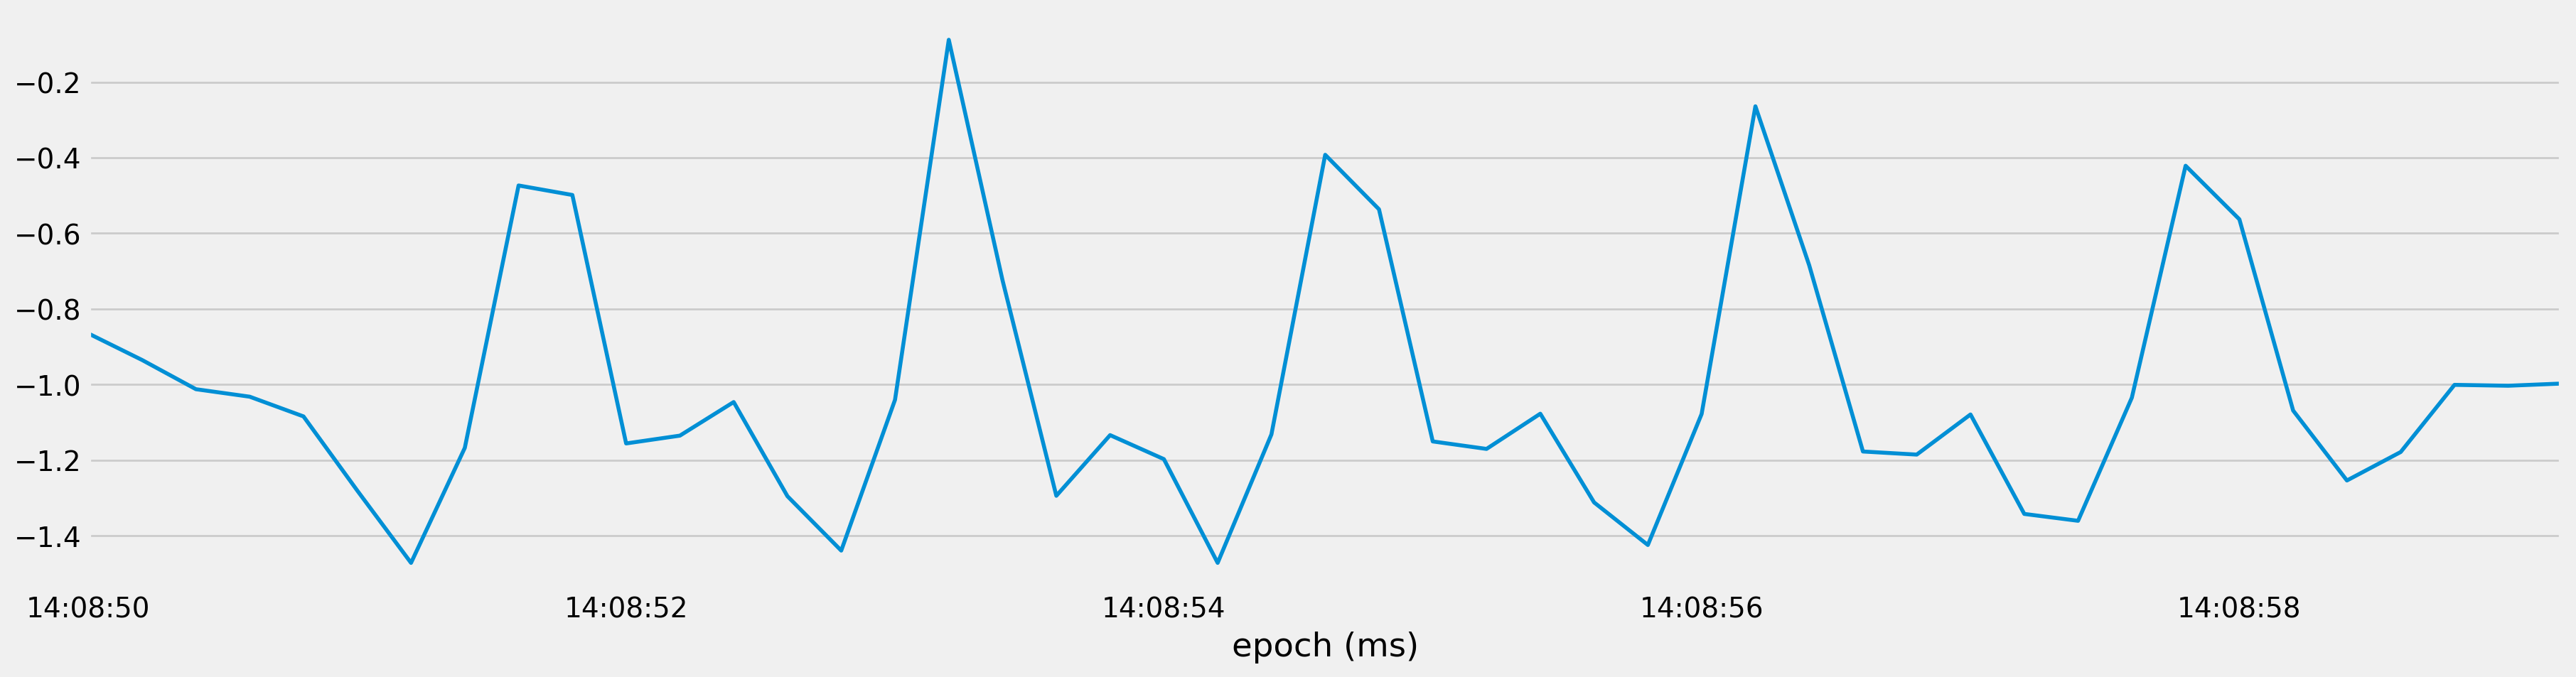

In [27]:
df[df.set == 50]["acc_y"].plot()


In [28]:
duration = df[df.set == 1].index[-1] - df[df.set == 1].index[0]
duration.seconds


16

Time delta = 16.4 seconds

In [29]:
df[df.set == 1].acc_x


epoch (ms)
2019-01-11 15:10:08.400    0.003667
2019-01-11 15:10:08.600   -0.012500
2019-01-11 15:10:08.800   -0.028000
2019-01-11 15:10:09.000   -0.062000
2019-01-11 15:10:09.200   -0.096667
                             ...   
2019-01-11 15:10:24.000    0.038667
2019-01-11 15:10:24.200    0.018500
2019-01-11 15:10:24.400    0.019667
2019-01-11 15:10:24.600    0.009500
2019-01-11 15:10:24.800    0.021000
Name: acc_x, Length: 83, dtype: float64

We can use df.loc to add a column and append the time delta to each row

In [30]:
for s in df.set.unique():
    start = df[df.set == s].index[0]
    end = df[df.set == s].index[-1]
    duration = end - start
    df.loc[df.set == s, "duration"] = duration.seconds

In [31]:
duration_df = df.groupby(["category"]).duration.mean()
# heavy set
duration_df[0] / 5
# medium set
duration_df[1] / 10

2.4942528735632186

### Butterworth lowpass filter

In [32]:
df_lowpass = df.copy()
LowPass = LowPassFilter()


In [40]:
# Frequency samples
# We resample the data to (200ms) per step (record)
fs = 1000 / 200  # 5 per second

# Start exploring with different cutoff frequencies until we get a good result
cutoff = 1.2


In [41]:
df_lowpass = LowPass.low_pass_filter(df_lowpass, "acc_y", fs, cutoff, order=5)

In [38]:
subset = df_lowpass[df_lowpass.set == 40]

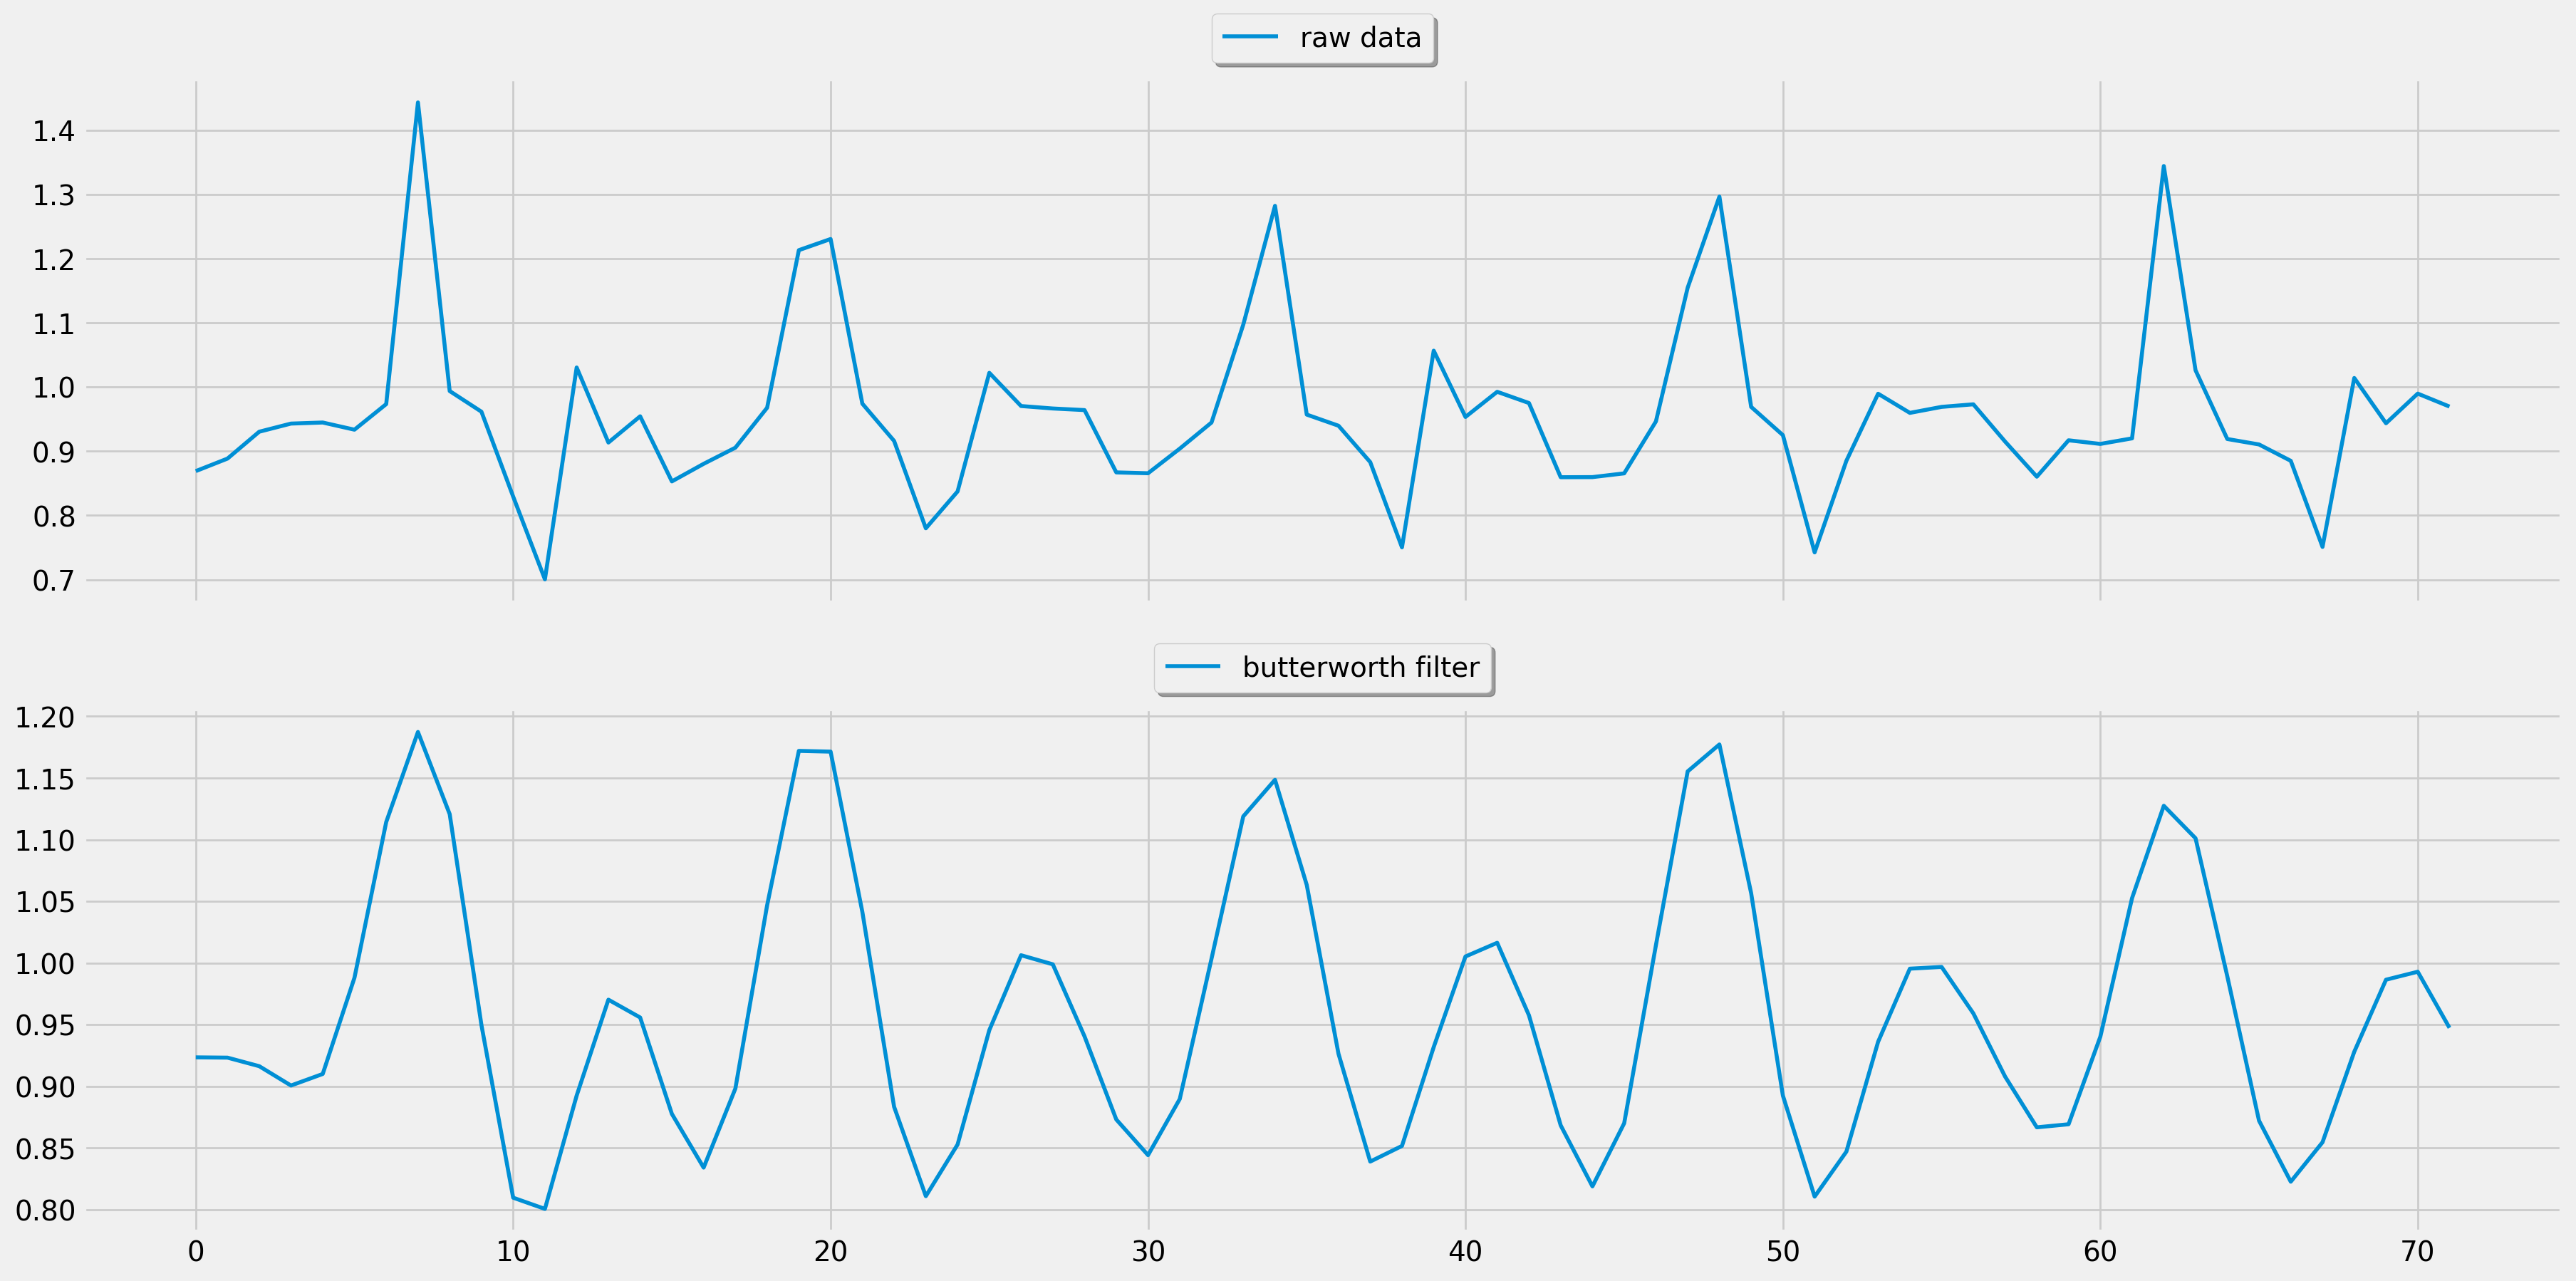

In [42]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))
ax[0].plot(subset["acc_y"].reset_index(drop=True), label="raw data")
ax[1].plot(subset["acc_y_lowpass"].reset_index(drop=True), label="butterworth filter")
ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=True)

In [43]:
for col in predictor_columns:
    df_lowpass = LowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[
        col + "_lowpass"
    ]  # overwrite the original column and delte
    del df_lowpass[col + "_lowpass"]


In [44]:
df_lowpass

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,label,category,participant,set,duration
epoch (ms),,,,,,,,,,,
2019-01-11 15:08:05.200,0.013494,0.977001,-0.070995,-1.896395,2.439080,0.939616,bench,heavy,B,30.0,16.0
2019-01-11 15:08:05.400,0.006869,0.970257,-0.067545,2.129685,0.528678,-1.248135,bench,heavy,B,30.0,16.0
2019-01-11 15:08:05.600,-0.009603,0.963589,-0.073447,4.151973,-2.092258,-0.929804,bench,heavy,B,30.0,16.0
2019-01-11 15:08:05.800,-0.022998,0.965441,-0.083731,2.074477,-3.626288,0.880509,bench,heavy,B,30.0,16.0
2019-01-11 15:08:06.000,-0.020032,0.966784,-0.093783,1.041930,-1.219897,-2.260590,bench,heavy,B,30.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...
2019-01-20 17:33:27.000,-0.045056,-0.974791,-0.061752,3.273522,-4.487268,0.133850,row,medium,E,90.0,19.0
2019-01-20 17:33:27.200,-0.042806,-1.020916,-0.057715,-2.514546,-2.449224,1.255524,row,medium,E,90.0,19.0
2019-01-20 17:33:27.400,-0.047074,-1.051656,-0.066326,-0.673530,-1.799975,1.193779,row,medium,E,90.0,19.0


# Principal component analysis PCA


# Sum of squares attributes


# Temporal abstraction


# Frequency features


# Dealing with overlapping windows


# Clustering


# Export dataset
